# Figure 1 / Table 2 - An analysis of metrical style

## Rationale

We measure 21 metrical features per line (20 are binary, elisions are counted), covering foot patterns, pauses, ictus/accent conflict and elision. We claim that works have a 'typical' style which is represented by the centroid of their vectorised lines. We further claim that authorial style can be differentiated using these features. Finally, we claim that the Mahalanobis distance of a set of lines from the centroid allows us to detect metrical outliers.

## Method

We transform the Punica with our hexameter vectoriser. The centroid is calculated by selecting 10,000 contiguous 81-line chunks at random from the full _Punica_ (including the Additamentum). We then _remove_ the Additamentum from the set of vectors and take a rolling window of 81-line chunks throughout the Punica, advancing at each step by 9 lines. At each step we take the Mahalanobis distance of this chunk from the centroid. The Mahalanobis distance is chosen for this analysis because it corrects for correlation/covariance, and there is significant correlation between certain metrical features (as just one example, a weak caesura can never appear in a spondaic foot). The distance of the Additamentum is then added to the final figure.

## Limitations

By removing the Additamentum from the lines used for the rolling window we create some distortion. Chunks that would overlap the Additamentum instead 'wrap around' it, so they are not truly contiguous. A chunk starting at 8:104 would contain 8:104 - 8:143 and then 8:223-263. The reason these lines were removed is that the alternative is even more confusing--the figure would contain many chunks that overlap the Additamentum and would therefore have artificially high scores (due to the strangeness of the metre in the Additamentum), making the Additamentum appear (on the figure) to be less unusual than it really is. This removal does NOT affect the calculation of the p-values when determining the confidence of the result, nor does it inflate the score for the Additamentum (since the centroid is calculated from a distribution that includes those lines).

The support for the claim that "authorial style can be differentiated with this measure" is not included here. This was shown via classification experiments using 4 different supervised classification algorithms. The full details are now available in *Digital Scholarhsip in the Humanities* [here](https://academic.oup.com/dsh/advance-article-abstract/doi/10.1093/llc/fqaa043/6154356) (doi:10.1093/llc/fqaa043), with accompanying code and data [here](https://github.com/bnagy/hexml-paper).

In [1]:
from mqdq import hexameter_corpus
from mqdq import utils
from mqdq import line_analyzer as la
from mqdq import mahalanobis as maha

import numpy as np
import pandas as pd
import scipy as sp

# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, cross_validate

In [2]:
# sklearn can be noisy.

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load R magic for Jupyter

%load_ext rpy2.ipython

In [4]:
%%capture
%%R

# Setup R stuff. Not sure if I use all of this, it's my standard bundle.

pacman::p_load(
    tidyverse,forcats,
    readxl,microbenchmark,ggsci,
    gapminder,broom,purrrlyr,knitr,
    DT,htmlTable, grid, ggpubr
)

In [5]:
# The MQDQParser package has this corpus pre-cleaned and
# built in.
#
# For this to work you'll need to pip install mqdq-parser
# (I'd suggest a virtual environment or something)

corp = hexameter_corpus.geezit_corpus()

100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.35s/it]


In [6]:
corp.columns

Index(['LN', 'Book', 'Work', 'Author', 'XML'], dtype='object')

In [7]:
# Each entry is an XML line. The data is from MQDQ http://mizar.unive.it/mqdq/public/index
# The XML files are provided under a Create Commons license.

corp.XML[0]

<line metre="H" name="1" pattern="DDSS">
<word sy="1A1b" wb="CF">Arma</word>
<word sy="1c2A2b" wb="CF">uirumque</word>
<word sy="2c3A" wb="CM">cano,</word>
<word sy="3T4A" wb="CM">Troiae</word>
<word sy="4T" wb="DI">qui</word>
<word sy="5A5b" wb="CF">primus</word>
<word sy="5c" wb="DI">ab</word>
<word sy="6A6X">oris</word>
</line>

In [8]:
# Perform the vectorisation

vecs_byauth = hexameter_corpus.vectorize_prosody(corp, by='Author')
vecs_bya_na = vecs_byauth.query('Author != "PsSilius"')
vecs_bywork =  hexameter_corpus.vectorize_prosody(corp, by='Work')

In [9]:
# This is what the data looks like. Everything but ELC (Elision Count)
# is a binary indicator. The vector for each chunk is just the centroid
# for that chunk (the vector containing the average value per feature)

vecs_bywork[:5]

,1SP,2SP,3SP,4SP,1CF,2CF,3CF,4CF,1DI,2DI,...,1SC,2SC,3SC,4SC,1WC,2WC,3WC,4WC,ELC,Work
0,0,0,1,1,0,0,1,1,0,0,...,0,0,1,1,1,1,0,0,0,Aeneid
1,0,1,0,1,1,1,1,1,0,0,...,0,1,1,1,0,0,0,0,0,Aeneid
2,0,1,1,1,0,0,1,1,1,0,...,0,0,1,1,0,0,0,0,2,Aeneid
3,0,1,0,1,0,1,1,1,0,0,...,1,1,1,1,0,0,0,0,0,Aeneid
4,0,1,1,1,0,1,1,1,0,0,...,0,1,1,1,1,0,0,0,1,Aeneid


In [10]:
# These are the lines with no Additamentum (12119 in total)

puni_vecs_na = vecs_byauth.query('Author == "Silius"').reset_index(drop=True)

In [11]:
puni_vecs = vecs_bywork.query('Work == "Punica"').reset_index(drop=True) # includes Addit
puni_vecs_shuf = puni_vecs.sample(frac=1, random_state=42)
addit_vecs = vecs_byauth.query('Author == "PsSilius"').reset_index(drop=True)

# Here we create a sampled distribution from the vectors supplied. 10000 entries, each
# entry is an 81-line chunk. The final calculation uses the covariance matrix calculated
# from this distribution to correct for feature correlation.

PUNI_DIST = maha._create_sampled_dist(puni_vecs_shuf, chunksz=81, distsz=10000, seed=42)

In [12]:
# This is a quick method built to produce the 'per feature' scores shown in Table 2.
# The scores for each feature sum to produce the squared Mahalanobis distance.

maha.lazy_compare(addit_vecs, puni_vecs, rd=PUNI_DIST)

------------------------------
M-dist 57.85,  p-value: 0.0000
Feat 	 Score 	 Samp% 	 Dist%
------------------------------
2WC    19.37     0.00    11.48
1WC    14.55    23.46     9.52
4DI     7.37    35.80    50.81
1CF     6.14    28.40    42.48
1DI     4.73    22.22    29.44
4SC     2.87    66.67    60.16
3SC     2.49    79.01    81.80
2DI     1.75     4.94     7.53
3CF     1.74    87.65    84.30
3WC     1.69     9.88    12.22
4SP     0.75    76.54    72.64
1SC     0.73    34.57    30.68
3DI     0.30    12.35    10.52
4WC     0.30     6.17     4.89
3SP     0.30    59.26    61.33
2SP    -0.17    62.96    56.36
ELC    -0.41    51.85    44.17
1SP    -0.55    43.21    50.61
2SC    -1.41    72.84    62.86
4CF    -1.43    64.20    60.74
2CF    -3.27    82.72    78.42
------------------------------


In [13]:
# The negative values here show how the algorithm compensates
# for correlation. 4SC and 4CF are strongly correlated (r=0.810),
# so although the 4CF value is also low some distance is actually
# subtracted from the final score because that difference has 
# 'already been counted'

maha.lazy_compare(puni_vecs[5652:5652+81], puni_vecs, rd=PUNI_DIST)

------------------------------
M-dist 61.60,  p-value: 0.0000
Feat 	 Score 	 Samp% 	 Dist%
------------------------------
4SC    40.07    34.57    60.16
3SP     7.81    76.54    61.33
3DI     4.40    18.52    10.52
4DI     4.28    41.98    50.81
4WC     4.07    11.11     4.89
1DI     2.94    23.46    29.44
4SP     2.91    79.01    72.64
1SP     2.00    58.02    50.61
1SC     1.87    23.46    30.68
2WC     1.67     9.88    11.48
2CF     1.15    76.54    78.42
2DI     0.89     3.70     7.53
1WC     0.81    12.35     9.52
1CF     0.60    49.38    42.48
3CF     0.31    88.89    84.30
3SC     0.24    87.65    81.80
2SP     0.12    54.32    56.36
2SC    -0.40    64.20    62.86
ELC    -0.62    46.91    44.17
3WC    -1.34     9.88    12.22
4CF   -12.17    45.68    60.74
------------------------------


In [14]:
# Now we perform the rolling-window sample, and calculate
# the M-distance for each entry

CHUNKSZ=81
STEP=9

res_rdist = []
for cut in np.arange(0,len(puni_vecs_na)-CHUNKSZ,STEP):
    samp = puni_vecs_na[cut:cut+CHUNKSZ]
    if len(samp) != CHUNKSZ:
        raise RuntimeError("incorrect chunk size!")
    m, _, _ = maha.chunk_explain(samp, puni_vecs_na, rd=PUNI_DIST)
    res_rdist.append(m)

In [15]:
sp.stats.describe(res_rdist)

DescribeResult(nobs=1338, minmax=(8.782356137897146, 61.598934886971534), mean=25.38880445182654, variance=62.760966200698256, skewness=0.6222385509303271, kurtosis=0.41111063473521847)

In [16]:
# Tidy up the data
silius_m_var = pd.DataFrame(zip(np.arange(0,len(puni_vecs)-CHUNKSZ,STEP), res_rdist))
silius_m_var.columns=['L', 'M']

addit_m_dist = maha.chunk_explain(addit_vecs, puni_vecs, n=10000, seed=42, rd=PUNI_DIST)[0]

In [17]:
# The only huge outlier that doesn't overlap the Additamentum (5230:5311)
# starts at 5652. There are also three more in that neighbourhood which
# have high scores for the same reason (although I have not performed that
# analysis with very much rigor)

# Note that because we removed the Additamentum from the rolling window
# every chunk that starts after line 5230 has had its index shifted back by 81

weird_chunks = silius_m_var[silius_m_var['M']>addit_m_dist]
weird_chunks = weird_chunks.reset_index()
weird_chunks['L'] = weird_chunks['L'].astype('int64')
weird_chunks

,index,L,M
0,619,5571,61.598935


In [18]:
# These were calculated elsewhere, they are just more friendly X-axis
# labels than using the line indices.

labs = pd.DataFrame(
 [(0, '1.1'),
 (871, '2.178'),
 (1742, '3.342'),
 (2613, '4.500'),
 (3484, '5.542'),
 (4355, '7.19'),
 (5226, '8.140'),
 (6097, '9.333'),
 (6968, '10.547'),
 (7839, '12.149'),
 (8710, '13.269'),
 (9581, '14.245'),
 (10452, '15.428'),
 (11323, '16.478'),
 (12194, '17.649')]
)
labs.columns=['line','ref']

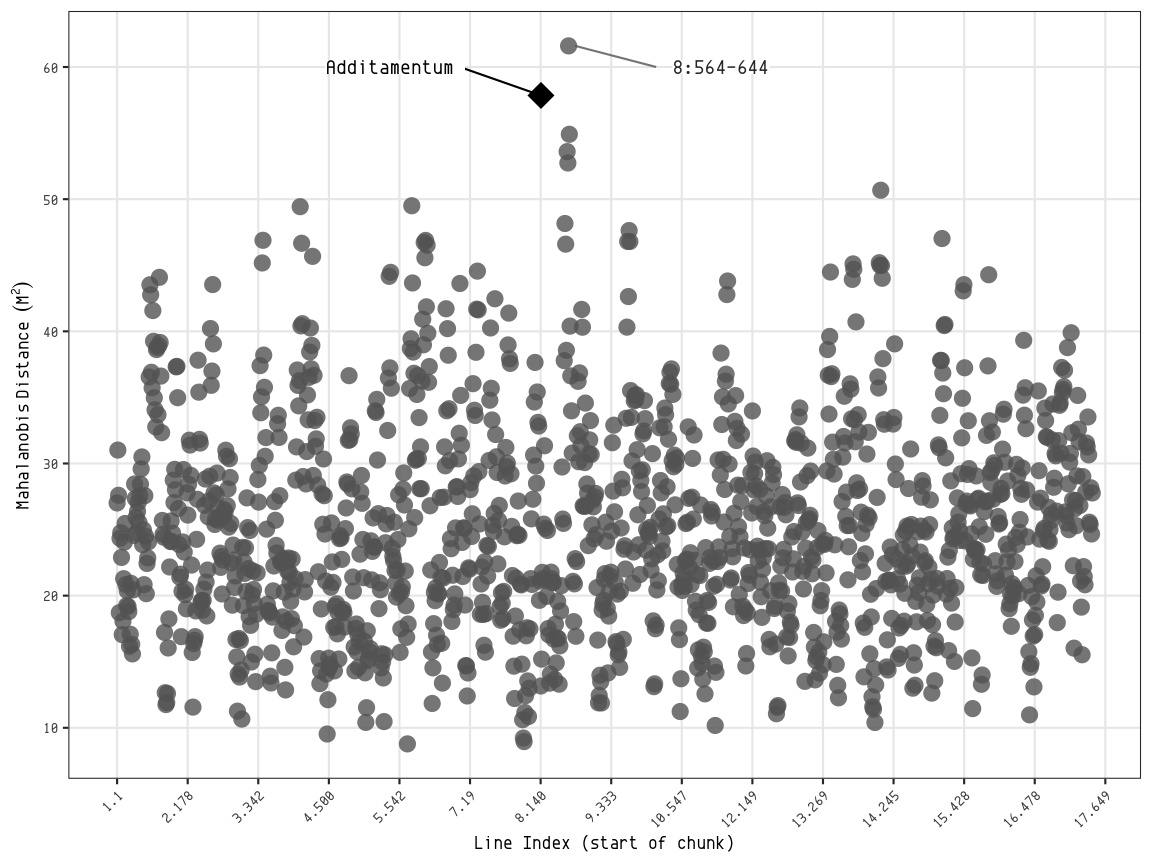

In [19]:
%%R -i silius_m_var,addit_m_dist,labs -h 6 -w 8 -u in -r 144

ggplot(data=silius_m_var,aes(x=L, y=M)) +
geom_point(alpha=0.8, shape=16, colour="grey40", size=3.7) +

# Add and annotate the data point for the Additamentum
annotate("point", color='black', size=6, alpha=1, shape=18, x=5230, y=addit_m_dist) +
annotate("segment", x = 5230 - 1000, xend = 5230, y = 60, yend = addit_m_dist, colour = "black") +
geom_label(
    color='black',
    label.size=NA,
    label.padding = unit(0.00, "lines"),
    family="Envy Code R",
    x=5230 - 1800 ,y=60,
    label="Additamentum ",
    size=3.5,
) +

annotate("segment", x = 5652, xend = 5652 + 1000, y = 61.6, yend = 60, colour = "grey40", alpha=0.8) +
geom_label(
    color='grey20',
    label.size=NA,
    label.padding = unit(0.00, "lines"),
    family="Envy Code R",
    x=5652 + 1800 ,y=60,
    label="8:564-644",
    size=3.5,
) +

theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.position='none') +
theme(plot.title = element_text(margin = margin(b = 50))) +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_y_continuous(breaks = scales::pretty_breaks(n = 6)) +
scale_x_continuous(breaks=labs$line, labels=labs$ref) +
labs(x="Line Index (start of chunk)",y=expression(Mahalanobis~Distance~~(M^2)))

# fn <- "/Users/ben/silius/mdists_cq_bw.pdf"
# ggsave(fn, dpi=600, width=8, height=6, device=cairo_pdf)
# embed_fonts(fn)